# Unscented Kalman Filter

The unscented kalman filter is an alternative approach to the extended kalman filter. Instead of linearizing the state transition model and measurement model to compute the probability distribution, the unscented kalman filter computes the posterior distribution by generating sigma points that capture the first and second moment of the a priori distribution, propogating the sigma points through the non-linearity, and computing the posterior distribution using the propogated points.

## Motion Models

In the extended Kalman filter module we used one of the most basic motion models where we assumed that the objects were moving at constant velocity. In This section we will explore more advance motion models.

- Constant Turn Rate and Velocity Magnitude (CTRV)
- Constant Turn Rate and Acceleration (CTA)
- Constant Steering Angle and Velocity (CSAV)
- Constant Curvature and Acceleration (CCA)

All of the models can be used with an extended kalman filter or unscented kalman filter.

**Constant Turn Rate and Velocity Model**

This model uses velocity magnitude, yaw angle and yaw rate instead of the cartesian velocity. 

<img src='images/crtv_model.png'/>

The state vector is now represented as

$
x=
\begin{bmatrix}
p_x \\
p_y \\
v \\
\psi \\
\dot{\psi} \\
\end{bmatrix}
$

Now lets derive the state transition function that maps $x_k$ to $x_{k+1}$. The first step will be to derive $\dot{x}$.

$
\dot{x}=
\begin{bmatrix}
\dot{p}_x \\
\dot{p}_y \\
\dot{v} \\
\dot{\psi} \\
\ddot{\psi} \\
\end{bmatrix}
=
\begin{pmatrix}
v\cdot\cos(\psi) \\
v\cdot\sin(\psi) \\
0 \\
\dot{\psi} \\
0 \\
\end{pmatrix}
$

The model we are using assumes that the longitudinal velocity and turn rate are constant so the acceleration terms are equal to zero. To find the state transition matrix we now need to integrate $\dot{x}$. For the equations below we will define $\Delta t$ as $t_{k+1} - t_k$.

$
x_{t_k + 1} = x_{t_k} + \int_{t_k}^{t_{k+1}} \dot{x}
=x_{t_k} + 
\begin{bmatrix}
\frac{v_k}{\dot{\psi}_k}(sin(\psi_k+\dot{\psi}_k \Delta t) - sin(\psi_k)) \\
\frac{v_k}{\dot{\psi}_k}(-cos(\psi_k+\dot{\psi}_k \Delta t) + cos(\psi_k)) \\
0 \\
\dot{\psi}_k \Delta t \\
0 \\
\end{bmatrix}
$

Under the condition that the yaw rate is zero the object is following a straight line and the equation becomes

$
x_{t_k + 1} =
x_{t_k} + 
\begin{bmatrix}
v_k cos(\psi_k) \Delta t \\
v_k sin(\psi_k) \Delta t \\
0 \\
0 \\
0 \\
\end{bmatrix}
$

The state transition function at this point has been computed using the state vector and it's derivative. We now need to incorporate process noise. In reality the longitudinal velocity and the turn rate are not constant. To account for this we will define the process noise in terms of the longitudinal acceleration and turn acceleration. Both of these parameters will be modeled as normally distributed random variables with zero mean. Using these variables we will incorporate them in the state transition function and process noise covariance matrix.

$
\begin{align}
\nu_{a,k} = \mathcal{N}(0, \sigma^2_{a}) \\
\nu_{\ddot{\psi},l} = \mathcal{N}(0, \sigma^2_{\ddot{\psi}})
\end{align}
$

Lets take a look at how the longitudinal acceleration and yaw acceleration affect the state transition function. To do this we just add the contribution of $\nu_{a}$ and $\nu_{\ddot{\psi}}$ to each row of the state transition function using elementary physics.

$
x_{t_k + 1} =
x_{t_k} + 
\begin{bmatrix}
\frac{v_k}{\dot{\psi}_k}(sin(\psi_k+\dot{\psi}_k \Delta t) - sin(\psi_k)) \\
\frac{v_k}{\dot{\psi}_k}(-cos(\psi_k+\dot{\psi}_k \Delta t) + cos(\psi_k)) \\
0 \\
\dot{\psi}_k \Delta t \\
0 \\
\end{bmatrix}
+
\begin{bmatrix}
a \\
b \\
c \\
d \\
e \\
\end{bmatrix}
$

$
\begin{align}
a &= \frac{\Delta t^2}{2} cos(\psi_k)\nu_{a,k} \\
b &= \frac{\Delta t^2}{2} sin(\psi_k)\nu_{a,k} \\
c &= \Delta t \nu_{a,k} \\
d &= \frac{\Delta t^2}{2}\nu_{\ddot{\psi},k} \\
e &= \Delta t \nu_{\ddot{\psi},k} \\
\end{align}
$

We can now compute the process covariance, Q using the formula below

$
Q = [\nu_k \cdot \nu_k^T]
$

## Unscented Kalman Filter

The unscented kalman filter handles computing the posterior distribution when the process model or measurement model are nonlinear in a different way than the extended kalman filter. The main problem that is being addressed is the gaussian is not preserved when passed through a nonlinear function. The objective of the unscented kalman filter is to provide the best estimate of a gaussian that represents the true posterior distribution.

The way that it does this is by passing representative points of the original gaussian distribution through the nonlinear function and then computing the covariance of those points. These points are called sigma points. 

**UKF Flow**
- Prediction
    * Generate sigma points
    * Predict sigma points
    * Predict Mean and Covariance
- Update
    * Predict Measurement
    * Update state
    
<img src='images/generating_sigma_points.png'/>

To compute the sigma points the following formula is used

$
X_{k|K} = 
\begin{bmatrix}
x_{k|k} & x_{k|k} + \sqrt{(\lambda + n_x)P_{k|k}} & x_{k|k} - \sqrt{(\lambda + n_x)P_{k|k}}
\end{bmatrix}
$

The $\lambda$ term is a design parameter that adjusts the spread of the sigma points. Imagine each column of P and lambda is a scalar multiplier applied to that. A common choice is to set 

$
\lambda = 3 - n_x
$

Below is an implementation in python of a sigma point generator. This can be easily transfered to C++ in the project. 

*Note: There are many weighting schemes for the unscented transform. The most popular appears to be the scaled unscented transform.*

In [ ]:
import numpy as np

# state vector
x = np.array([5.7441, 1.3800, 2.2049, 0.5015, 0.3528])
x = x[np.newaxis].T

# state vector length
nx = x.shape[0]

# lambda
l = 3 - nx

print("x=\n{}".format(x))

P = np.array([[0.0043,   -0.0013,    0.0030,   -0.0022,   -0.0020,],
              [-0.0013,    0.0077,    0.0011,    0.0071,    0.0060,],
              [0.0030,    0.0011,    0.0054,    0.0007,    0.0008,],
              [-0.0022,    0.0071,    0.0007,    0.0098,    0.0100,],
              [-0.0020,    0.0060,    0.0008,    0.0100,    0.0123]])

print("P=\n{}".format(P))

# sqrt of P
A = np.linalg.cholesky(P)

# sigma points
X = np.zeros((5,11), dtype=np.double)
X = np.asmatrix(X)

# compute sigma point array
X[:,0] = x
X[:,1:nx+1] = x + np.sqrt(l + nx)*A
X[:,-nx:] = x - np.sqrt(1 + nx)*A

print("X=\n{}".format(X))

We need to incorporate the the process model noises in our belief, $\nu_a$ and $\nu_{\dot{\psi}}$. To do this we are going to augment the state vector and covariance matrix to include the process model noise parameters.

$
x_{a}=
\begin{bmatrix}
p_x \\
p_y \\
v \\
\psi \\
\dot{\psi} \\
\nu_a \\
\nu_{\ddot{\psi}} \\
\end{bmatrix}
$

and 

$
P_{a} =
\begin{bmatrix}
P & 0 \\
0 & Q \\
\end{bmatrix}
$

Once the sigma points have been computed at k, we need to predict where the sigma points will be at k+1 by applying the state transition function to each sigma point. The state transition function was defined above in the motion model section. Once the sigma points have been propogated through the state transition function we can compute the mean and covariance using them.

<img src="images/predicted_covariance.png"/>

This completes the prediction step for the unscented kalman filter. 

Now we must perform the measurement update. To do the measurement update we are going to use the predicted sigma points generated by the prediction step. These will be passed through the measurement function and the measurement covariance will be computed using the transformed points. In this case the sensor noise is purely additive so we don't need to worry about the sensor covariance when doing this step.

<img src="images/measurement_covariance.png"/>

Now that we have the predicted measurement and measurement covariance all we need to is compute the new state and covariance using the standard kalman filter equations with a minor update. The kalman gain is computed using a cross corelation between the measurement and state covariance.

<img src="images/measurement_update.png"/>

## Filter Performance

The cell below provides plots that can be used to evaluate the filters performance.

0


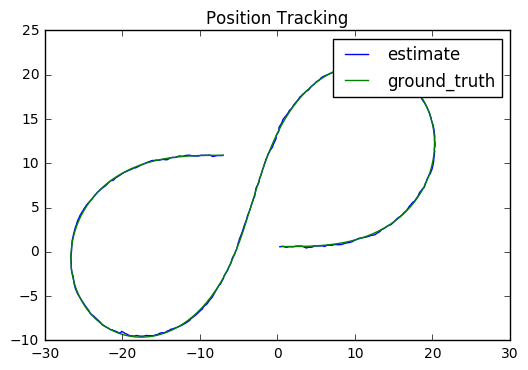

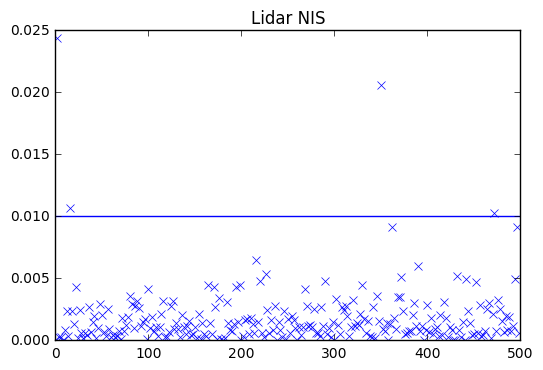

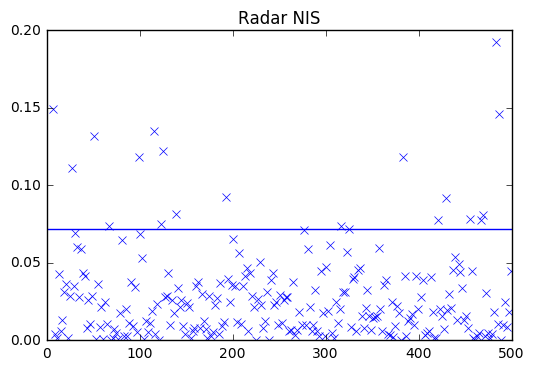

In [43]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

out = subprocess.call(["sh", "compile.sh"])
print(out)

ds = pd.read_table("output/output.txt")

plt.figure()
plt.title("Position Tracking")
plt.plot(ds.px_state, ds.py_state)
plt.plot(ds.px_ground_truth, ds.py_ground_truth)
plt.legend(['estimate', 'ground_truth'])
plt.show()

plt.figure()
plt.title("Lidar NIS")
plt.plot(ds[ds.sensor_type == 'lidar'].NIS, "x")
plt.axhline(0.010)
plt.show()

plt.figure()
plt.title("Radar NIS")
plt.plot(ds[ds.sensor_type == 'radar'].NIS, "x")
plt.axhline(0.072)
plt.ylim([0, 0.2])
plt.show()